# Assignment 1. Given amazon-book dataset in the folder "Data/": 

Questions: Build the NGCF model to learn the amazon-book dataset

In [1]:

import os
import numpy as np
import random as rd
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
from time import time
from sklearn.metrics import roc_auc_score
import warnings

class NGCF(nn.Module):
    def __init__(self, n_user, n_item, norm_adj, args):
        super(NGCF, self).__init__()
        self.n_user = n_user
        self.n_item = n_item
        self.device = args.device
        self.emb_size = args.embed_size
        self.batch_size = args.batch_size
        self.node_dropout = args.node_dropout[0]
        self.mess_dropout = args.mess_dropout
        self.batch_size = args.batch_size
        self.norm_adj = norm_adj
        self.layers = args.layer_size
        self.decay = args.regs[0]

        self.embedding_dict, self.weight_dict = self.init_weight()
        self.sparse_norm_adj = self._convert_sp_mat_to_sp_tensor(self.norm_adj).to(self.device)

    def init_weight(self):
        initializer = nn.init.xavier_uniform_

        embedding_dict = nn.ParameterDict({
            'user_emb': nn.Parameter(initializer(torch.empty(self.n_user, self.emb_size))),
            'item_emb': nn.Parameter(initializer(torch.empty(self.n_item, self.emb_size)))
        })

        weight_dict = nn.ParameterDict()
        layers = [self.emb_size] + self.layers
        for k in range(len(self.layers)):
            weight_dict.update({
                'W_gc_%d'%k: nn.Parameter(initializer(torch.empty(layers[k], layers[k+1]))),
                'b_gc_%d'%k: nn.Parameter(initializer(torch.empty(1, layers[k+1]))),
                'W_bi_%d'%k: nn.Parameter(initializer(torch.empty(layers[k], layers[k+1]))),
                'b_bi_%d'%k: nn.Parameter(initializer(torch.empty(1, layers[k+1])))
            })
        return embedding_dict, weight_dict

    def _convert_sp_mat_to_sp_tensor(self, X):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            coo = X.tocoo()
            i = torch.LongTensor([coo.row, coo.col])
            v = torch.from_numpy(coo.data).float()
            return torch.sparse.FloatTensor(i, v, coo.shape)

    def sparse_dropout(self, x, rate, noise_shape):
        random_tensor = 1 - rate
        random_tensor += torch.rand(noise_shape).to(x.device)
        dropout_mask = torch.floor(random_tensor).type(torch.bool)
        i = x._indices()
        v = x._values()

        i = i[:, dropout_mask]
        v = v[dropout_mask]

        out = torch.sparse.FloatTensor(i, v, x.shape).to(x.device)
        return out * (1. / (1 - rate))

    def create_bpr_loss(self, users, pos_items, neg_items):
        pos_scores = torch.sum(torch.mul(users, pos_items), axis=1)
        neg_scores = torch.sum(torch.mul(users, neg_items), axis=1)
        maxi = nn.LogSigmoid()(pos_scores - neg_scores)
        mf_loss = -1 * torch.mean(maxi)
        regularizer = (torch.norm(users) ** 2 + torch.norm(pos_items) ** 2 + torch.norm(neg_items) ** 2) / 2
        emb_loss = self.decay * regularizer / self.batch_size
        return mf_loss + emb_loss, mf_loss, emb_loss

    def rating(self, u_g_embeddings, pos_i_g_embeddings):
        return torch.matmul(u_g_embeddings, pos_i_g_embeddings.t())

    def forward(self, users, pos_items, neg_items, drop_flag=True):
        A_hat = self.sparse_dropout(self.sparse_norm_adj, self.node_dropout, self.sparse_norm_adj._nnz()) if drop_flag else self.sparse_norm_adj
        ego_embeddings = torch.cat([self.embedding_dict['user_emb'], self.embedding_dict['item_emb']], 0)
        all_embeddings = [ego_embeddings]

        for k in range(len(self.layers)):
            side_embeddings = torch.sparse.mm(A_hat, ego_embeddings)
            sum_embeddings = torch.matmul(side_embeddings, self.weight_dict['W_gc_%d' % k]) + self.weight_dict['b_gc_%d' % k]
            bi_embeddings = torch.mul(ego_embeddings, side_embeddings)
            bi_embeddings = torch.matmul(bi_embeddings, self.weight_dict['W_bi_%d' % k]) + self.weight_dict['b_bi_%d' % k]
            ego_embeddings = nn.LeakyReLU(negative_slope=0.2)(sum_embeddings + bi_embeddings)
            ego_embeddings = nn.Dropout(self.mess_dropout[k])(ego_embeddings)
            norm_embeddings = F.normalize(ego_embeddings, p=2, dim=1)
            all_embeddings += [norm_embeddings]

        all_embeddings = torch.cat(all_embeddings, 1)
        u_g_embeddings = all_embeddings[:self.n_user, :]
        i_g_embeddings = all_embeddings[self.n_user:, :]

        u_g_embeddings = u_g_embeddings[users, :]
        pos_i_g_embeddings = i_g_embeddings[pos_items, :]
        neg_i_g_embeddings = i_g_embeddings[neg_items, :]

        return u_g_embeddings, pos_i_g_embeddings, neg_i_g_embeddings

In [2]:
import numpy as np
import random as rd
import scipy.sparse as sp
from time import time

class Data(object):
    def __init__(self, path, batch_size):
        self.path = path
        self.batch_size = batch_size

        train_file = path + '/train.txt'
        test_file = path + '/test.txt'

        #get number of users and items
        self.n_users, self.n_items = 0, 0
        self.n_train, self.n_test = 0, 0
        self.neg_pools = {}

        self.exist_users = []

        with open(train_file) as f:
            for l in f.readlines():
                if len(l) > 0:
                    l = l.strip('\n').split(' ')
                    items = [int(i) for i in l[1:]]
                    uid = int(l[0])
                    self.exist_users.append(uid)
                    self.n_items = max(self.n_items, max(items))
                    self.n_users = max(self.n_users, uid)
                    self.n_train += len(items)

        with open(test_file) as f:
            for l in f.readlines():
                if len(l) > 0:
                    l = l.strip('\n')
                    try:
                        items = [int(i) for i in l.split(' ')[1:]]
                    except Exception:
                        continue
                    self.n_items = max(self.n_items, max(items))
                    self.n_test += len(items)
        self.n_items += 1
        self.n_users += 1

        self.print_statistics()

        self.R = sp.dok_matrix((self.n_users, self.n_items), dtype=np.float32)

        self.train_items, self.test_set = {}, {}
        with open(train_file) as f_train:
            with open(test_file) as f_test:
                for l in f_train.readlines():
                    if len(l) == 0:
                        break
                    l = l.strip('\n')
                    items = [int(i) for i in l.split(' ')]
                    uid, train_items = items[0], items[1:]

                    for i in train_items:
                        self.R[uid, i] = 1.
                        # self.R[uid][i] = 1

                    self.train_items[uid] = train_items

                for l in f_test.readlines():
                    if len(l) == 0: break
                    l = l.strip('\n')
                    try:
                        items = [int(i) for i in l.split(' ')]
                    except Exception:
                        continue

                    uid, test_items = items[0], items[1:]
                    self.test_set[uid] = test_items

    def get_adj_mat(self):
        try:
            t1 = time()
            adj_mat = sp.load_npz(self.path + '/s_adj_mat.npz')
            norm_adj_mat = sp.load_npz(self.path + '/s_norm_adj_mat.npz')
            mean_adj_mat = sp.load_npz(self.path + '/s_mean_adj_mat.npz')
            print('already load adj matrix', adj_mat.shape, time() - t1)

        except Exception:
            adj_mat, norm_adj_mat, mean_adj_mat = self.create_adj_mat()
            sp.save_npz(self.path + '/s_adj_mat.npz', adj_mat)
            sp.save_npz(self.path + '/s_norm_adj_mat.npz', norm_adj_mat)
            sp.save_npz(self.path + '/s_mean_adj_mat.npz', mean_adj_mat)
        return adj_mat, norm_adj_mat, mean_adj_mat

    def create_adj_mat(self):
        t1 = time()
        adj_mat = sp.dok_matrix((self.n_users + self.n_items, self.n_users + self.n_items), dtype=np.float32)
        adj_mat = adj_mat.tolil()
        R = self.R.tolil()

        adj_mat[:self.n_users, self.n_users:] = R
        adj_mat[self.n_users:, :self.n_users] = R.T
        adj_mat = adj_mat.todok()
        print('already create adjacency matrix', adj_mat.shape, time() - t1)

        t2 = time()

        def mean_adj_single(adj):
            # D^-1 * A
            rowsum = np.array(adj.sum(1))

            d_inv = np.power(rowsum, -1).flatten()
            d_inv[np.isinf(d_inv)] = 0.
            d_mat_inv = sp.diags(d_inv)

            norm_adj = d_mat_inv.dot(adj)
            # norm_adj = adj.dot(d_mat_inv)
            print('generate single-normalized adjacency matrix.')
            return norm_adj.tocoo()

        def normalized_adj_single(adj):
            # D^-1/2 * A * D^-1/2
            rowsum = np.array(adj.sum(1))

            d_inv_sqrt = np.power(rowsum, -0.5).flatten()
            d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
            d_mat_inv_sqrt = sp.diags(d_inv_sqrt)

            # bi_lap = adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt)
            bi_lap = d_mat_inv_sqrt.dot(adj).dot(d_mat_inv_sqrt)
            return bi_lap.tocoo()

        def check_adj_if_equal(adj):
            dense_A = np.array(adj.todense())
            degree = np.sum(dense_A, axis=1, keepdims=False)

            temp = np.dot(np.diag(np.power(degree, -1)), dense_A)
            print('check normalized adjacency matrix whether equal to this laplacian matrix.')
            return temp

        norm_adj_mat = mean_adj_single(adj_mat + sp.eye(adj_mat.shape[0]))
        # norm_adj_mat = normalized_adj_single(adj_mat + sp.eye(adj_mat.shape[0]))
        mean_adj_mat = mean_adj_single(adj_mat)

        print('already normalize adjacency matrix', time() - t2)
        return adj_mat.tocsr(), norm_adj_mat.tocsr(), mean_adj_mat.tocsr()

    def negative_pool(self):
        t1 = time()
        for u in self.train_items.keys():
            neg_items = list(set(range(self.n_items)) - set(self.train_items[u]))
            pools = [rd.choice(neg_items) for _ in range(100)]
            self.neg_pools[u] = pools
        print('refresh negative pools', time() - t1)

    def sample(self):
        if self.batch_size <= self.n_users:
            users = rd.sample(self.exist_users, self.batch_size)
        else:
            users = [rd.choice(self.exist_users) for _ in range(self.batch_size)]

        def sample_pos_items_for_u(u, num):
            # sample num pos items for u-th user
            pos_items = self.train_items[u]
            n_pos_items = len(pos_items)
            pos_batch = []
            while True:
                if len(pos_batch) == num:
                    break
                pos_id = np.random.randint(low=0, high=n_pos_items, size=1)[0]
                pos_i_id = pos_items[pos_id]

                if pos_i_id not in pos_batch:
                    pos_batch.append(pos_i_id)
            return pos_batch

        def sample_neg_items_for_u(u, num):
            # sample num neg items for u-th user
            neg_items = []
            while True:
                if len(neg_items) == num:
                    break
                neg_id = np.random.randint(low=0, high=self.n_items,size=1)[0]
                if neg_id not in self.train_items[u] and neg_id not in neg_items:
                    neg_items.append(neg_id)
            return neg_items

        def sample_neg_items_for_u_from_pools(u, num):
            neg_items = list(set(self.neg_pools[u]) - set(self.train_items[u]))
            return rd.sample(neg_items, num)

        pos_items, neg_items = [], []
        for u in users:
            pos_items += sample_pos_items_for_u(u, 1)
            neg_items += sample_neg_items_for_u(u, 1)

        return users, pos_items, neg_items

    def get_num_users_items(self):
        return self.n_users, self.n_items

    def print_statistics(self):
        print('n_users=%d, n_items=%d' % (self.n_users, self.n_items))
        print('n_interactions=%d' % (self.n_train + self.n_test))
        print('n_train=%d, n_test=%d, sparsity=%.5f' % (self.n_train, self.n_test, (self.n_train + self.n_test)/(self.n_users * self.n_items)))

    def get_sparsity_split(self):
        try:
            split_uids, split_state = [], []
            lines = open(self.path + '/sparsity.split', 'r').readlines()

            for idx, line in enumerate(lines):
                if idx % 2 == 0:
                    split_state.append(line.strip())
                    print(line.strip())
                else:
                    split_uids.append([int(uid) for uid in line.strip().split(' ')])
            print('get sparsity split.')

        except Exception:
            split_uids, split_state = self.create_sparsity_split()
            f = open(self.path + '/sparsity.split', 'w')
            for idx in range(len(split_state)):
                f.write(split_state[idx] + '\n')
                f.write(' '.join([str(uid) for uid in split_uids[idx]]) + '\n')
            print('create sparsity split.')

        return split_uids, split_state

    def create_sparsity_split(self):
        all_users_to_test = list(self.test_set.keys())
        user_n_iid = dict()

        # generate a dictionary to store (key=n_iids, value=a list of uid).
        for uid in all_users_to_test:
            train_iids = self.train_items[uid]
            test_iids = self.test_set[uid]

            n_iids = len(train_iids) + len(test_iids)

            if n_iids not in user_n_iid.keys():
                user_n_iid[n_iids] = [uid]
            else:
                user_n_iid[n_iids].append(uid)
        split_uids = list()

        # split the whole user set into four subset.
        temp = []
        count = 1
        fold = 4
        n_count = (self.n_train + self.n_test)
        n_rates = 0

        split_state = []
        for idx, n_iids in enumerate(sorted(user_n_iid)):
            temp += user_n_iid[n_iids]
            n_rates += n_iids * len(user_n_iid[n_iids])
            n_count -= n_iids * len(user_n_iid[n_iids])

            if n_rates >= count * 0.25 * (self.n_train + self.n_test):
                split_uids.append(temp)

                state = '#inter per user<=[%d], #users=[%d], #all rates=[%d]' %(n_iids, len(temp), n_rates)
                split_state.append(state)
                print(state)

                temp = []
                n_rates = 0
                fold -= 1

            if idx == len(user_n_iid.keys()) - 1 or n_count == 0:
                split_uids.append(temp)

                state = '#inter per user<=[%d], #users=[%d], #all rates=[%d]' % (n_iids, len(temp), n_rates)
                split_state.append(state)
                print(state)

        return split_uids, split_state

In [3]:
class ReducedData(Data):
    def __init__(self, path, batch_size, sample_ratio=0.1):
        self.path = path
        self.batch_size = batch_size
        self.sample_ratio = sample_ratio

        train_file = path + '/train.txt'
        test_file = path + '/test.txt'

        self.n_users, self.n_items = 0, 0
        self.n_train, self.n_test = 0, 0
        self.neg_pools = {}
        self.exist_users = []

        all_users = set()
        all_items = set()

        with open(train_file) as f:
            for l in f.readlines():
                if len(l) > 0:
                    l = l.strip('\n').split(' ')
                    uid = int(l[0])
                    items = [int(i) for i in l[1:]]
                    all_users.add(uid)
                    all_items.update(items)

        with open(test_file) as f:
            for l in f.readlines():
                if len(l) > 0:
                    try:
                        l = l.strip('\n').split(' ')
                        uid = int(l[0])
                        items = [int(i) for i in l[1:]]
                        all_users.add(uid)
                        all_items.update(items)
                    except Exception:
                        continue

        n_sample_users = int(len(all_users) * sample_ratio)
        self.sampled_users = np.random.choice(list(all_users), size=n_sample_users, replace=False)
        self.sampled_users = set(self.sampled_users)

        self.user_id_map = {old_id: new_id for new_id, old_id in enumerate(sorted(self.sampled_users))}
        self.item_id_map = {old_id: new_id for new_id, old_id in enumerate(sorted(all_items))}

        self.n_users = len(self.user_id_map)
        self.n_items = len(self.item_id_map)

        print(f"Sampled {self.n_users} users and {self.n_items} items")

        self.R = sp.dok_matrix((self.n_users, self.n_items), dtype=np.float32)
        self.train_items, self.test_set = {}, {}

        with open(train_file) as f:
            for l in f.readlines():
                if len(l) > 0:
                    l = l.strip('\n').split(' ')
                    uid = int(l[0])

                    if uid not in self.sampled_users:
                        continue

                    mapped_uid = self.user_id_map[uid]
                    items = [int(i) for i in l[1:]]
                    mapped_items = [self.item_id_map[item] for item in items]

                    self.exist_users.append(mapped_uid)
                    self.train_items[mapped_uid] = mapped_items
                    self.n_train += len(mapped_items)

                    for i in mapped_items:
                        self.R[mapped_uid, i] = 1.

        with open(test_file) as f:
            for l in f.readlines():
                if len(l) > 0:
                    try:
                        l = l.strip('\n').split(' ')
                        uid = int(l[0])

                        if uid not in self.sampled_users:
                            continue

                        mapped_uid = self.user_id_map[uid]
                        items = [int(i) for i in l[1:]]
                        mapped_items = [self.item_id_map[item] for item in items]

                        self.test_set[mapped_uid] = mapped_items
                        self.n_test += len(mapped_items)
                    except Exception:
                        continue

        self.print_statistics()

    def get_adj_mat(self):
        try:
            adj_mat = sp.load_npz(self.path + '/s_adj_mat.npz')
            norm_adj_mat = sp.load_npz(self.path + '/s_norm_adj_mat.npz')
            mean_adj_mat = sp.load_npz(self.path + '/s_mean_adj_mat.npz')
            print('already load adj matrix', adj_mat.shape)

            adj_mat = self.create_adj_mat()
            norm_adj_mat = self.normalize_adj_mat(adj_mat + sp.eye(adj_mat.shape[0]))
            mean_adj_mat = self.normalize_adj_mat(adj_mat)

        except Exception:
            adj_mat = self.create_adj_mat()
            norm_adj_mat = self.normalize_adj_mat(adj_mat + sp.eye(adj_mat.shape[0]))
            mean_adj_mat = self.normalize_adj_mat(adj_mat)

        return adj_mat, norm_adj_mat, mean_adj_mat

    def create_adj_mat(self):
        t1 = time()
        adj_mat = sp.dok_matrix((self.n_users + self.n_items, self.n_users + self.n_items), dtype=np.float32)
        adj_mat = adj_mat.tolil()
        R = self.R.tolil()

        adj_mat[:self.n_users, self.n_users:] = R
        adj_mat[self.n_users:, :self.n_users] = R.T
        adj_mat = adj_mat.todok()
        print('already create adjacency matrix', adj_mat.shape, time() - t1)

        return adj_mat

    def normalize_adj_mat(self, adj):
        """Normalize adjacency matrix."""
        rowsum = np.array(adj.sum(1))
        d_inv = np.power(rowsum, -0.5).flatten()
        d_inv[np.isinf(d_inv)] = 0.
        d_mat_inv = sp.diags(d_inv)
        norm_adj = d_mat_inv.dot(adj).dot(d_mat_inv)
        return norm_adj.tocsr()

In [4]:
import numpy as np
from sklearn.metrics import roc_auc_score

def recall(rank, ground_truth, N):
    return len(set(rank[:N]) & set(ground_truth)) / float(len(set(ground_truth)))

def precision_at_k(r, k):
    """Score is precision @ k
    Relevance is binary (nonzero is relevant).
    Returns:
        Precision @ k
    Raises:
        ValueError: len(r) must be >= k
    """
    assert k >= 1
    r = np.asarray(r)[:k]
    return np.mean(r)

def average_precision(r,cut):
    """Score is average precision (area under PR curve)
    Relevance is binary (nonzero is relevant).
    Returns:
        Average precision
    """
    r = np.asarray(r)
    out = [precision_at_k(r, k + 1) for k in range(cut) if r[k]]
    if not out:
        return 0.
    return np.sum(out)/float(min(cut, np.sum(r)))

def mean_average_precision(rs):
    """Score is mean average precision
    Relevance is binary (nonzero is relevant).
    Returns:
        Mean average precision
    """
    return np.mean([average_precision(r) for r in rs])

def dcg_at_k(r, k, method=1):
    """Score is discounted cumulative gain (dcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Returns:
        Discounted cumulative gain
    """
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.

def ndcg_at_k(r, k, ground_truth, method=1):
    """Score is normalized discounted cumulative gain (ndcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Returns:
        Normalized discounted cumulative gain

        Low but correct defination
    """
    GT = set(ground_truth)
    if len(GT) > k :
        sent_list = [1.0] * k
    else:
        sent_list = [1.0]*len(GT) + [0.0]*(k-len(GT))
    dcg_max = dcg_at_k(sent_list, k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

def recall_at_k(r, k, all_pos_num):
    # if all_pos_num == 0:
    #     return 0
    r = np.asfarray(r)[:k]
    return np.sum(r) / all_pos_num

def hit_at_k(r, k):
    r = np.array(r)[:k]
    if np.sum(r) > 0:
        return 1.
    else:
        return 0.

def F1(pre, rec):
    if pre + rec > 0:
        return (2.0 * pre * rec) / (pre + rec)
    else:
        return 0.

def AUC(ground_truth, prediction):
    try:
        res = roc_auc_score(y_true=ground_truth, y_score=prediction)
    except Exception:
        res = 0.
    return res

In [7]:
import argparse
import os
import torch
import numpy as np
from time import time
import torch.optim as optim
import torch.nn as nn
import ast
import gc

def parse_args():
    parser = argparse.ArgumentParser(description="Run NGCF.")
    parser.add_argument('--data_path', nargs='?', default='./Data/',
                        help='Input data path.')
    parser.add_argument('--dataset', nargs='?', default='amazon-book',
                        help='a dataset from amazon-book')
    parser.add_argument('--embed_size', type=int, default=64,
                        help='Embedding size.')
    parser.add_argument('--layer_size', nargs='?', default='[64,32,16]',
                        help='Output sizes of every layer')
    parser.add_argument('--batch_size', type=int, default=256,
                        help='Batch size.')
    parser.add_argument('--regs', type=str, default='[1e-5]',
                        help='Regularizations.')
    parser.add_argument('--lr', type=float, default=0.0001,
                        help='Learning rate.')
    parser.add_argument('--epoch', type=int, default=5,
                        help='Number of epoch.')
    parser.add_argument('--verbose', type=int, default=1,
                        help='Interval of evaluation.')
    parser.add_argument('--node_dropout', nargs='?', default='[0.1]',
                        help='Keep probability w.r.t. node dropout (i.e., 1-dropout_ratio) for each deep layer.')
    parser.add_argument('--mess_dropout', nargs='?', default='[0.1,0.1,0.1]',
                        help='Keep probability w.r.t. message dropout (i.e., 1-dropout_ratio) for each deep layer.')
    parser.add_argument('--save_flag', type=int, default=1,
                        help='0: Disable model saver, 1: Save model and training stats')
    parser.add_argument('--sample_ratio', type=float, default=0.005,
                        help='Ratio of data to use (0~1)')

    return parser.parse_args([])

def free_memory():
    gc.collect()
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

def main():
    warnings.filterwarnings('ignore')
    args = parse_args()

    original_path = os.path.join(args.data_path, f"{args.dataset}_reduced_{int(args.sample_ratio*100)}p")

    args.layer_size = ast.literal_eval(args.layer_size)
    args.node_dropout = ast.literal_eval(args.node_dropout)
    args.mess_dropout = ast.literal_eval(args.mess_dropout)
    args.regs = ast.literal_eval(args.regs)
    args.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    data_generator = ReducedData(
        path=args.data_path + '/' + args.dataset,
        batch_size=args.batch_size,
        sample_ratio=args.sample_ratio
    )

    adj_mat, norm_adj_mat, mean_adj_mat = data_generator.get_adj_mat()

    free_memory()


    model = NGCF(data_generator.n_users,
                 data_generator.n_items,
                 norm_adj_mat,
                 args).to(args.device)


    optimizer = optim.Adam(model.parameters(), lr=args.lr)


    for epoch in range(args.epoch):
        t1 = time()
        loss, mf_loss, reg_loss = 0., 0., 0.
        n_batch = data_generator.n_train // args.batch_size + 1

        model.train()

        for idx in range(n_batch):
            users, pos_items, neg_items = data_generator.sample()

            users = torch.LongTensor(users).to(args.device)
            pos_items = torch.LongTensor(pos_items).to(args.device)
            neg_items = torch.LongTensor(neg_items).to(args.device)

            u_g_embeddings, pos_i_g_embeddings, neg_i_g_embeddings = model(users,
                                                                         pos_items,
                                                                         neg_items,
                                                                         drop_flag=True)

            batch_loss, batch_mf_loss, batch_reg_loss = model.create_bpr_loss(u_g_embeddings,
                                                                             pos_i_g_embeddings,
                                                                             neg_i_g_embeddings)
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            loss += batch_loss
            mf_loss += batch_mf_loss
            reg_loss += batch_reg_loss

        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}, Time: {time()-t1:.2f}s')

if __name__ == '__main__':
    main()

Sampled 263 users and 91599 items
n_users=263, n_items=91599
n_interactions=13756
n_train=10998, n_test=2758, sparsity=0.00057
already create adjacency matrix (91862, 91862) 1.0942473411560059
Epoch 1, Loss: 32.5118, Time: 3.49s
Epoch 2, Loss: 31.4149, Time: 3.75s
Epoch 3, Loss: 30.3558, Time: 3.94s
Epoch 4, Loss: 29.7238, Time: 3.93s
Epoch 5, Loss: 29.1122, Time: 3.94s


# Assignment 2. Follow the LightGCN in Practice code

Questions: 
1. Modify the LightGCN model with dropout layers after each LGConv layer. Print out the results.
2. Visualize embedding distribution of representations of user and item embeddings using t-SNE or PCA


In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ngannkim/bxcsvdump")

print("Path to dataset files:", path)

Path to dataset files: /home/user/.cache/kagglehub/datasets/ngannkim/bxcsvdump/versions/1


In [12]:
from zipfile import ZipFile
import os

# Path to the extracted dataset
dataset_path = '/home/user/.cache/kagglehub/datasets/ngannkim/bxcsvdump/versions/1'

# Check if the directory exists and list the files
if os.path.exists(dataset_path):
    # List files in the dataset path
    files = os.listdir(dataset_path)
    print("Files in the dataset directory:", files)

    # Open a specific file if needed, for example 'BX-Books.csv'
    books_file = os.path.join(dataset_path, 'BX-Books.csv')
    with open(books_file, 'r', encoding='latin-1') as f:
        # Process the file (e.g., read data, print the first few lines)
        print("First 5 lines of BX-Books.csv:")
        for i in range(5):
            print(f.readline().strip())
else:
    print("Dataset directory does not exist.")

Files in the dataset directory: ['BX-Books.csv', 'BX-Users.csv', 'BX-Book-Ratings.csv']
First 5 lines of BX-Books.csv:
"ISBN";"Book-Title";"Book-Author";"Year-Of-Publication";"Publisher";"Image-URL-S";"Image-URL-M";"Image-URL-L"
"0195153448";"Classical Mythology";"Mark P. O. Morford";"2002";"Oxford University Press";"http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg";"http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg";"http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg"
"0002005018";"Clara Callan";"Richard Bruce Wright";"2001";"HarperFlamingo Canada";"http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg";"http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg";"http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg"
"0060973129";"Decision in Normandy";"Carlo D'Este";"1991";"HarperPerennial";"http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg";"http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg";"http://images.amazo

In [14]:
import pandas as pd
import os

# Define the base path to your dataset
base_path = '/home/user/.cache/kagglehub/datasets/ngannkim/bxcsvdump/versions/1'

# Define file paths
ratings_file = os.path.join(base_path, 'BX-Book-Ratings.csv')
users_file = os.path.join(base_path, 'BX-Users.csv')
books_file = os.path.join(base_path, 'BX-Books.csv')

# Load the datasets with appropriate options
ratings = pd.read_csv(ratings_file, sep=';', encoding='latin-1')
users = pd.read_csv(users_file, sep=';', encoding='latin-1')
books = pd.read_csv(books_file, sep=';', encoding='latin-1', on_bad_lines='skip')

In [15]:
ratings.head(5)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [16]:
users.head(5)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [17]:
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch import nn, optim, Tensor

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn import LGConv

In [18]:
# Preprocessing
ratings = ratings.loc[ratings['ISBN'].isin(books['ISBN'].unique()) & ratings['User-ID'].isin(users['User-ID'].unique())]

# Keep the 100k highest ratings
ratings = ratings[ratings['Book-Rating'] >= 8].iloc[:100000]

In [19]:
# Create mappings
user_mapping = {userid: i for i, userid in enumerate(ratings['User-ID'].unique())}
item_mapping = {isbn: i for i, isbn in enumerate(ratings['ISBN'].unique())}

# Count users and items
num_users = len(user_mapping)
num_items = len(item_mapping)
num_total = num_users + num_items

In [20]:
# Build the adjacency matrix based on user ratings
user_ids = torch.LongTensor([user_mapping[i] for i in ratings['User-ID']])
item_ids = torch.LongTensor([item_mapping[i] for i in ratings['ISBN']])
edge_index = torch.stack((user_ids, item_ids))
# Create training, validation, and test adjacency matrices
train_index, test_index = train_test_split(range(len(ratings)), test_size=0.2, random_state=0)
val_index, test_index = train_test_split(test_index, test_size=0.5, random_state=0)

train_edge_index = edge_index[:, train_index]
val_edge_index = edge_index[:, val_index]
test_edge_index = edge_index[:, test_index]

In [21]:
def sample_mini_batch(edge_index):
    # Generate BATCH_SIZE random indices
    index = np.random.choice(range(edge_index.shape[1]), size=BATCH_SIZE)

    # Generate negative sample indices
    edge_index = structured_negative_sampling(edge_index)
    edge_index = torch.stack(edge_index, dim=0)

    user_index = edge_index[0, index]
    pos_item_index = edge_index[1, index]
    neg_item_index = edge_index[2, index]

    return user_index, pos_item_index, neg_item_index

In [22]:
class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, num_layers=4, dim_h=64, dropout_rate=0.3):
        super().__init__()

        self.num_users = num_users
        self.num_items = num_items
        self.num_layers = num_layers
        self.emb_users = nn.Embedding(num_embeddings=self.num_users, embedding_dim=dim_h)
        self.emb_items = nn.Embedding(num_embeddings=self.num_items, embedding_dim=dim_h)

        self.convs = nn.ModuleList(LGConv() for _ in range(num_layers))

        self.dropouts = nn.ModuleList(nn.Dropout(p=dropout_rate) for _ in range(num_layers))

        nn.init.normal_(self.emb_users.weight, std=0.01)
        nn.init.normal_(self.emb_items.weight, std=0.01)

    def forward(self, edge_index):
        emb = torch.cat([self.emb_users.weight, self.emb_items.weight])
        embs = [emb]

        for conv, dropout in zip(self.convs, self.dropouts):
            emb = conv(x=emb, edge_index=edge_index)
            emb = dropout(emb)
            embs.append(emb)

        emb_final = 1/(self.num_layers+1) * torch.mean(torch.stack(embs, dim=1), dim=1)

        emb_users_final, emb_items_final = torch.split(emb_final, [self.num_users, self.num_items])

        return emb_users_final, self.emb_users.weight, emb_items_final, self.emb_items.weight

In [23]:
def bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items):
    reg_loss = LAMBDA * (emb_users.norm().pow(2) +
                        emb_pos_items.norm().pow(2) +
                        emb_neg_items.norm().pow(2))

    pos_ratings = torch.mul(emb_users_final, emb_pos_items_final).sum(dim=-1)
    neg_ratings = torch.mul(emb_users_final, emb_neg_items_final).sum(dim=-1)

    bpr_loss = torch.mean(torch.nn.functional.softplus(pos_ratings - neg_ratings))
    # bpr_loss = torch.mean(torch.nn.functional.logsigmoid(pos_ratings - neg_ratings))

    return -bpr_loss + reg_loss

In [24]:
def get_user_items(edge_index):
    user_items = dict()
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_items:
            user_items[user] = []
        user_items[user].append(item)
    return user_items

In [25]:
def compute_recall_at_k(items_ground_truth, items_predicted):
    num_correct_pred = np.sum(items_predicted, axis=1)
    num_total_pred = np.array([len(items_ground_truth[i]) for i in range(len(items_ground_truth))])

    recall = np.mean(num_correct_pred / num_total_pred)

    return recall
def compute_ndcg_at_k(items_ground_truth, items_predicted):
    test_matrix = np.zeros((len(items_predicted), K))

    for i, items in enumerate(items_ground_truth):
        length = min(len(items), K)
        test_matrix[i, :length] = 1

    max_r = test_matrix
    idcg = np.sum(max_r * 1. / np.log2(np.arange(2, K + 2)), axis=1)
    dcg = items_predicted * (1. / np.log2(np.arange(2, K + 2)))
    dcg = np.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[np.isnan(ndcg)] = 0.

    return np.mean(ndcg)
# wrapper function to get evaluation metrics
def get_metrics(model, edge_index, exclude_edge_indices):

    ratings = torch.matmul(model.emb_users.weight, model.emb_items.weight.T)

    for exclude_edge_index in exclude_edge_indices:
        user_pos_items = get_user_items(exclude_edge_index)
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)
        ratings[exclude_users, exclude_items] = -1024

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(ratings, k=K)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    test_user_pos_items = get_user_items(edge_index)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    items_predicted = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        items_predicted.append(label)

    recall = compute_recall_at_k(test_user_pos_items_list, items_predicted)
    ndcg = compute_ndcg_at_k(test_user_pos_items_list, items_predicted)

    return recall, ndcg

In [26]:
# wrapper function to evaluate model
def test(model, edge_index, exclude_edge_indices):
    emb_users_final, emb_users, emb_items_final, emb_items = model.forward(edge_index)
    user_indices, pos_item_indices, neg_item_indices = structured_negative_sampling(edge_index, contains_neg_self_loops=False)

    emb_users_final, emb_users = emb_users_final[user_indices], emb_users[user_indices]

    emb_pos_items_final, emb_pos_items = emb_items_final[pos_item_indices], emb_items[pos_item_indices]
    emb_neg_items_final, emb_neg_items = emb_items_final[neg_item_indices], emb_items[neg_item_indices]

    loss = bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items).item()

    recall, ndcg = get_metrics(model, edge_index, exclude_edge_indices)

    return loss, recall, ndcg

In [27]:
K = 20
LAMBDA = 1e-6
BATCH_SIZE = 1024
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LightGCN(num_users, num_items)
model = model.to(device)
edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

n_batch = int(len(train_index)/BATCH_SIZE)

for epoch in range(31):
    model.train()

    for _ in range(n_batch):
        optimizer.zero_grad()

        emb_users_final, emb_users, emb_items_final, emb_items = model.forward(train_edge_index)

        user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(train_edge_index)

        emb_users_final, emb_users = emb_users_final[user_indices], emb_users[user_indices]
        emb_pos_items_final, emb_pos_items = emb_items_final[pos_item_indices], emb_items[pos_item_indices]
        emb_neg_items_final, emb_neg_items = emb_items_final[neg_item_indices], emb_items[neg_item_indices]

        train_loss = bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items)

        train_loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        model.eval()
        val_loss, recall, ndcg = test(model, val_edge_index, [train_edge_index])
        print(f"Epoch {epoch} | Train loss: {train_loss.item():.5f} | Val loss: {val_loss:.5f} | Val recall@{K}: {recall:.5f} | Val ndcg@{K}: {ndcg:.5f}")

Epoch 0 | Train loss: -0.69330 | Val loss: -0.69281 | Val recall@20: 0.00542 | Val ndcg@20: 0.00350
Epoch 5 | Train loss: -0.70803 | Val loss: -0.66413 | Val recall@20: 0.01608 | Val ndcg@20: 0.00754
Epoch 10 | Train loss: -0.78536 | Val loss: -0.55915 | Val recall@20: 0.01829 | Val ndcg@20: 0.00854
Epoch 15 | Train loss: -0.97415 | Val loss: -0.34326 | Val recall@20: 0.01732 | Val ndcg@20: 0.00850
Epoch 20 | Train loss: -1.29182 | Val loss: -0.01397 | Val recall@20: 0.01850 | Val ndcg@20: 0.00904
Epoch 25 | Train loss: -1.79838 | Val loss: 0.41171 | Val recall@20: 0.01848 | Val ndcg@20: 0.00879
Epoch 30 | Train loss: -2.70290 | Val loss: 0.92461 | Val recall@20: 0.01842 | Val ndcg@20: 0.00870


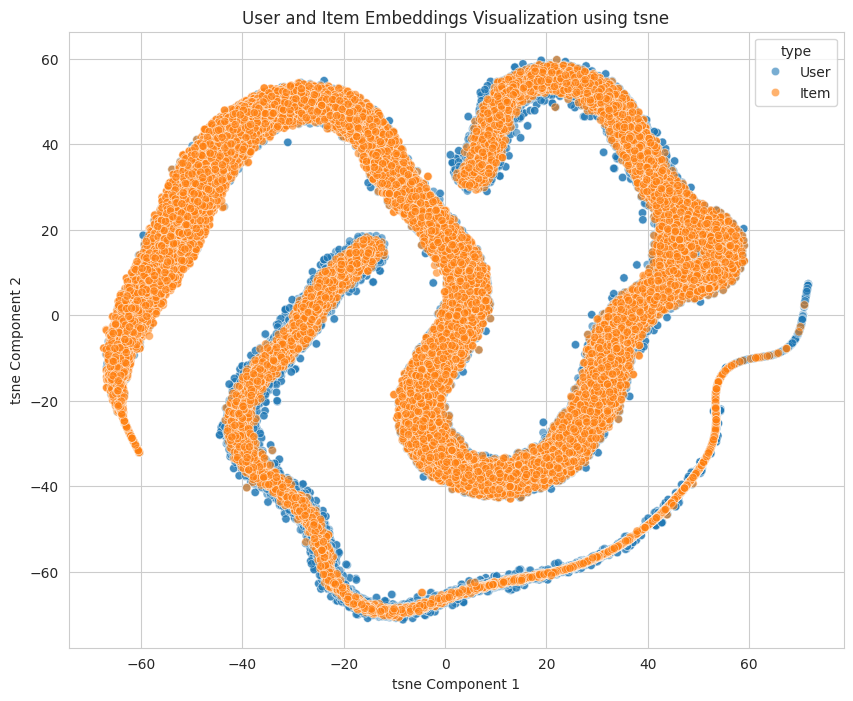

In [31]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_embeddings(user_embeddings, item_embeddings, method='tsne'):
    all_embeddings = np.vstack([user_embeddings, item_embeddings])

    labels = ['User'] * len(user_embeddings) + ['Item'] * len(item_embeddings)

    if method.lower() == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    else:  # PCA
        reducer = PCA(n_components=2)

    embeddings_2d = reducer.fit_transform(all_embeddings)

    import pandas as pd
    df = pd.DataFrame({
        'x': embeddings_2d[:, 0],
        'y': embeddings_2d[:, 1],
        'type': labels
    })

    plt.figure(figsize=(10, 8))
    sns.set_style('whitegrid')

    sns.scatterplot(data=df, x='x', y='y', hue='type', alpha=0.6)

    plt.title(f'User and Item Embeddings Visualization using {method}')
    plt.xlabel(f'{method} Component 1')
    plt.ylabel(f'{method} Component 2')

    plt.show()

def plot_model_embeddings(model, edge_index):
    # Move edge_index to the same device as the model
    edge_index = edge_index.to(next(model.parameters()).device)
    
    # Get embeddings from model
    with torch.no_grad():
        user_emb, _, item_emb, _ = model(edge_index)

    user_emb_np = user_emb.cpu().numpy()
    item_emb_np = item_emb.cpu().numpy()

    visualize_embeddings(user_emb_np, item_emb_np, method='tsne')

# Ensure edge_index is on the same device as the model
edge_index = torch.randint(0, num_users + num_items, (2, 10000)).to(device)

plot_model_embeddings(model, edge_index)
